In [1]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 图像预处理

In [3]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

### 载入图像分类数据集

In [5]:
# 数据集文件夹路径
dataset_dir = 'Particle Figures_split'

In [6]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 Particle Figures_split/train
测试集路径 Particle Figures_split/val


In [7]:
from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

In [8]:
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)

训练集图像数量 1000
类别个数 6
各类别名称 ['Angular', 'Rounded', 'Subangular', 'Subrounded', 'Very angular', 'Well rounded']


In [9]:
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

测试集图像数量 248
类别个数 6
各类别名称 ['Angular', 'Rounded', 'Subangular', 'Subrounded', 'Very angular', 'Well rounded']


### 类别和索引号 映射字典

In [11]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)

In [12]:
class_names

['Angular',
 'Rounded',
 'Subangular',
 'Subrounded',
 'Very angular',
 'Well rounded']

In [13]:
# 映射关系：类别 到 索引号
train_dataset.class_to_idx

{'Angular': 0,
 'Rounded': 1,
 'Subangular': 2,
 'Subrounded': 3,
 'Very angular': 4,
 'Well rounded': 5}

In [14]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [15]:
idx_to_labels

{0: 'Angular',
 1: 'Rounded',
 2: 'Subangular',
 3: 'Subrounded',
 4: 'Very angular',
 5: 'Well rounded'}

In [16]:
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)

### 定义数据加载器DataLoader 

In [17]:
from torch.utils.data import DataLoader

In [18]:
BATCH_SIZE = 32
#每一口32个数据
# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4   #windows用pycharm得改成1
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

### 查看一个batch的图像和标注

In [19]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))

In [20]:
images.shape

torch.Size([32, 3, 224, 224])

In [21]:
labels

tensor([4, 3, 0, 1, 5, 2, 1, 4, 5, 1, 1, 3, 3, 3, 3, 0, 1, 4, 2, 2, 2, 0, 2, 1,
        4, 2, 2, 0, 2, 3, 2, 3])

### 可视化一个batch的图像和标注

In [22]:
#将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

In [23]:
images[5].shape

(3, 224, 224)

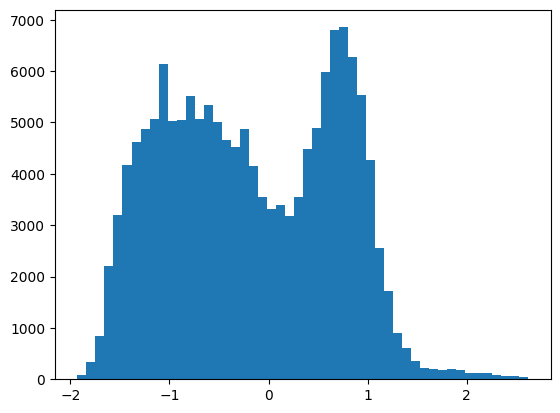

In [26]:
plt.hist(images[5].flatten(), bins=50)
plt.show()                   
#归一化已经把每一个像素都处理了，所以现在的像素都不是0-255的整数，而是一个以0为均值的有负有正的，这样的像素值更容易被神经网络处理。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:0')

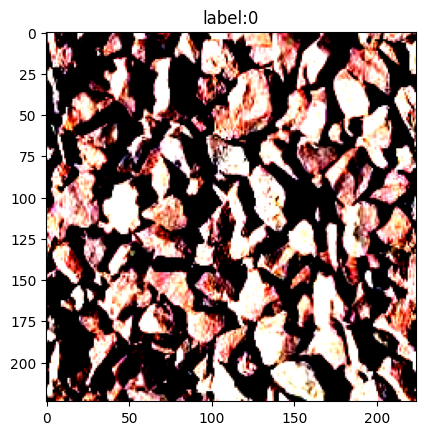

In [27]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [28]:
label = labels[idx].item()

In [29]:
label

0

In [30]:
pred_classname = idx_to_labels[label]

In [31]:
pred_classname

'Angular'

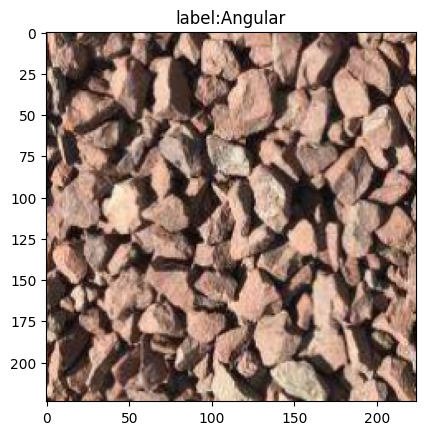

In [32]:
# 原始图像
idx = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()
#这是调取了一个batch的其中一张图像拿出来看看，实际的调试就是一口一口一个batch一个batch喂进去。

### 导入训练需使用的工具包

In [33]:
from torchvision import models
import torch.optim as optim

In [37]:
#迁移学习的几个方案，取决于自己的数据分布跟ImageNet数据分布的差异。第一种，相当于只换了一下最后的分类层，1000种变成30种这样，只训练换了的30层，其他都冻结

### 选择一：只微调训练模型最后一层（全连接分类层）

In [60]:
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)

In [61]:
model.fc

Linear(in_features=512, out_features=6, bias=True)

In [62]:
# 只微调训练最后一层全连接层的参数，其它层冻结  优化器Adam
optimizer = optim.Adam(model.fc.parameters())

### 选择二：微调训练所有层

In [63]:
#数据集跟ImageNet从分布上不太一样，比如说医疗、结构、轨道伤损这类的、制造业缺陷检测等，可以微调训练所有层（而不是只训练分类层）

In [64]:
#在模型的所有层都进行微调，微调也是以这个预训练模型初始化来调的，也是赢在起跑线上的，仍然可以复用一部分已经训练好的权重和特征。

In [65]:
# model = models.resnet18(pretrained=True) # 载入预训练模型

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

### 选择三：随机初始化模型全部权重，从头训练所有层

In [66]:
#数据集和ImageNet完全不一样，从尺寸、尺度环境等，像显微镜、天文望远镜这种。相当于不管ImageNet了，从头自己调一个Resnet18

In [67]:
# model = models.resnet18(pretrained=False) # 只载入模型结构，不载入预训练权重参数

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

### 训练配置

In [68]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()    #设定交叉熵损失函数

# 训练轮次 Epoch  训练遍历所有数据算一个Epoch，一个Epoch算每个batch都走完了
EPOCHS = 20

### 模拟一个batch的训练

In [69]:
# 获得一个 batch 的数据和标注
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

In [70]:
# 输入模型，执行前向预测
outputs = model(images)

In [71]:
# 获得当前 batch 所有图像的预测类别 logit 分数
outputs.shape

torch.Size([32, 6])

In [72]:
# 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
loss = criterion(outputs, labels)

In [73]:
#loss

In [74]:
# 反向传播“三部曲”    优化器梯度清零，反向传播求梯度，求得模型的权重该怎么微调能够使得损失函数最小化，接下来再去拧每一个水龙头，拧模型中的每一个权重，
#再按照之前规定的优化器，优化更新每一个权重
optimizer.zero_grad() # 清除梯度
loss.backward() # 反向传播
optimizer.step() # 优化更新

In [75]:
# 获得当前 batch 所有图像的预测类别  看最高置信度的几类
_, preds = torch.max(outputs, 1)

In [76]:
preds

tensor([2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 0, 3, 4, 2, 3, 3, 3, 3, 2, 2, 3, 3,
        3, 3, 3, 2, 2, 3, 4, 3], device='cuda:0')

In [77]:
labels

tensor([0, 0, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 3, 3, 5, 1, 0, 2, 2, 4, 1, 3, 4, 0,
        4, 3, 4, 4, 2, 2, 1, 2], device='cuda:0')

### 运行完整训练

In [78]:
# 遍历每个 EPOCH
for epoch in tqdm(range(EPOCHS)):

    model.train()

    for images, labels in train_loader:  # 获取训练集的一个 batch，包含数据和标注
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)           # 前向预测，获得当前 batch 的预测结果
        loss = criterion(outputs, labels) # 比较预测结果和标注，计算当前 batch 的交叉熵损失函数
        
        optimizer.zero_grad()
        loss.backward()                   # 损失函数对神经网络权重反向传播求梯度
        optimizer.step()                  # 优化更新神经网络权重

100%|██████████| 20/20 [01:10<00:00,  3.53s/it]


### 在测试集上初步测试

In [79]:
model.eval()                                #model又train改成eval
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader): # 获取测试集的一个 batch，包含数据和标注
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)              # 前向预测，获得当前 batch 的预测置信度
        _, preds = torch.max(outputs, 1)     # 获得最大置信度对应的类别，作为预测结果
        total += labels.size(0)
        correct += (preds == labels).sum()   # 预测正确样本个数

    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

100%|██████████| 8/8 [00:01<00:00,  5.02it/s]

测试集上的准确率为 51.210 %


### 保存模型

In [80]:
torch.save(model, 'checkpoint/Particle Figures_pytorch_C1.pth')